# **Red neuronal convolucional para el diagnóstico de nódulos tiroideos según la clasificación EU-TIRADS**

## Por Alejandro Martínez Hernández

### Notebook 3/3

# **Creación de modelos**

PAra la siguiente parte se crearan los siguientes modelos de clasificación simple:
- model1
- model2

## **MobileNetV3**

### **Small Version**

#### **Adam Optimizer**

Found 192 images belonging to 2 classes.


Found 47 images belonging to 2 classes.
Epoch 1/100


c:\Users\alema\Desktop\paper\nodulos_tiroideos\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 459ms/step - accuracy: 0.4705 - loss: 0.7270 - val_accuracy: 0.4468 - val_loss: 0.7019
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 234ms/step - accuracy: 0.4187 - loss: 0.7388 - val_accuracy: 0.4468 - val_loss: 0.6989
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 262ms/step - accuracy: 0.4462 - loss: 0.6994 - val_accuracy: 0.4468 - val_loss: 0.6962
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 283ms/step - accuracy: 0.4882 - loss: 0.7002 - val_accuracy: 0.4468 - val_loss: 0.6939
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 240ms/step - accuracy: 0.4500 - loss: 0.7139 - val_accuracy: 0.4468 - val_loss: 0.6979
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 247ms/step - accuracy: 0.4850 - loss: 0.6975 - val_accuracy: 0.4043 - val_loss: 0.6927
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 236ms/step - accuracy: 0.4405 - loss: 0.7060 - val_accuracy: 0.5319 - val_loss: 0.6918
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 251ms/step - accuracy: 0.5717 - loss: 0.6891 - val_accuracy: 0.5532 - val_loss: 0.6

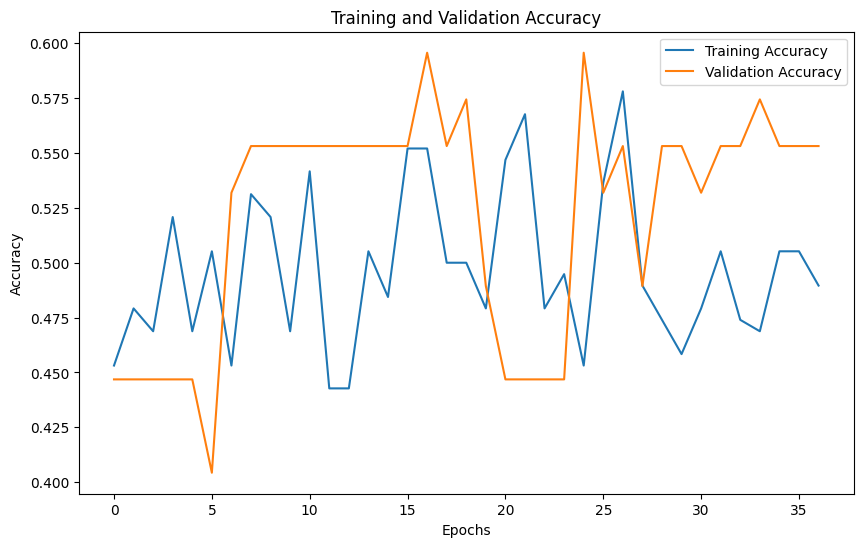

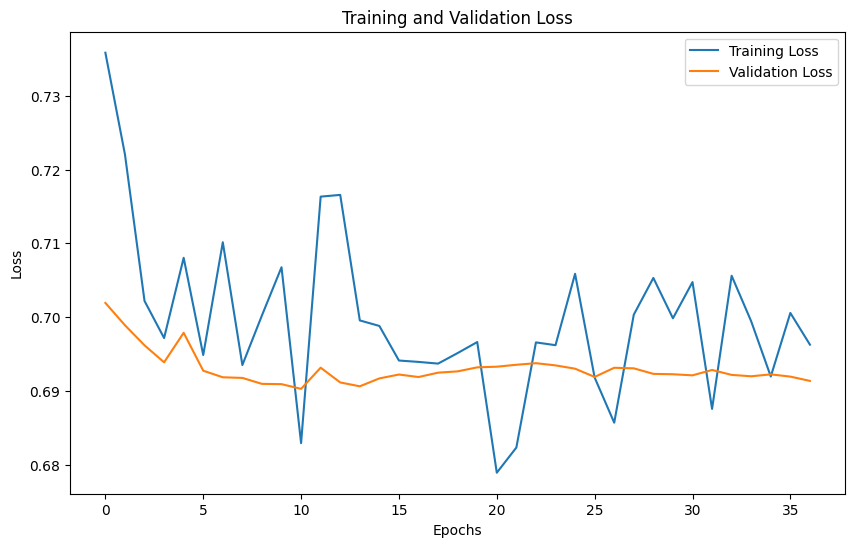

In [15]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV3Small
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Configurar generadores de imágenes con y sin aumento de datos
def setup_image_generators(base_dir, input_size=(224, 224), batch_size=5):
    """
    Configura generadores de imágenes para entrenamiento y validación.
    
    Args:
    base_dir (str): Directorio base donde están ubicadas las carpetas de imágenes.
    input_size (tuple): Tamaño al cual se redimensionarán las imágenes.
    batch_size (int): Número de imágenes por lote.

    Returns:
    train_generator, validation_generator: Generadores para el entrenamiento y validación.
    """
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=5,
        zoom_range=[0.5, 1.5],
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant',
        validation_split=0.2  # Reserva el 20% de los datos para validación
    )

    validation_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2
    )

    train_generator = train_datagen.flow_from_directory(
        base_dir,
        target_size=input_size,
        #batch_size=batch_size,
        class_mode='binary',
        subset='training'  # Especifica que este generador es para entrenamiento
    )

    validation_generator = validation_datagen.flow_from_directory(
        base_dir,
        target_size=input_size,
        #batch_size=batch_size,
        class_mode='binary',
        subset='validation'  # Especifica que este generador es para validación
    )

    return train_generator, validation_generator

def create_model(input_shape=(224, 224, 3)):
    """
    Crea un modelo de red neuronal secuencial utilizando MobileNetV3 como base.
    
    Args:
    input_shape (tuple): Dimensiones de las imágenes de entrada.
    num_classes (int): Número de clases para la clasificación. Se espera 2 para binaria.

    Returns:
    model: Modelo compilado de TensorFlow.
    """
    base_model = MobileNetV3Small(include_top=False, weights='imagenet', input_shape=input_shape)

    # Congelar el modelo base para reutilizar las características aprendidas en ImageNet
    base_model.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(10, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Cambio para clasificación binaria
    ])

    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Ruta al directorio de imágenes
base_directory = 'db_unal/organized/images/cropped'
train_gen, val_gen = setup_image_generators(base_directory)

# Crear y compilar el modelo
model = create_model()

# Calcular los pesos de clase para manejar datos desbalanceados
weights = compute_class_weight(
    class_weight='balanced',  # Especifica 'balanced' para ajustar automáticamente en base a la frecuencia de clases
    classes=np.unique(train_gen.classes),  # Obtener clases únicas de los datos de entrenamiento
    y=train_gen.classes)  # Etiquetas de clase reales para cada muestra de entrenamiento

# Crear un diccionario mapeando índices de clase a sus respectivos pesos calculados
class_weights = {i: weights[i] for i in range(len(weights))}

# Configurar el callback EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitorear la pérdida de validación
    min_delta=0.01,      # Cambio mínimo detectado como una mejora
    patience=30,          # Número de épocas sin mejora después de las cuales el entrenamiento será detenido
    verbose=1,           # Mostrar mensajes de progreso
    mode='min'           # 'min' porque queremos minimizar la pérdida
)

# Entrenar el modelo
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=100,
    class_weight=class_weights, # Ajuste de pesos para cada clase
    callbacks=[early_stopping]
)

# Performance Metrics

import matplotlib.pyplot as plt

# Retrieve accuracy results on training and validation data sets for each training epoch.
acc = history.history['accuracy']  # Training accuracy
val_acc = history.history['val_accuracy']  # Validation accuracy

# Retrieve loss results on training and validation data sets for each training epoch.
loss = history.history['loss']  # Training loss
val_loss = history.history['val_loss']  # Validation loss

# Determine the number of epochs, based on the length of the accuracy list.
epochs = range(len(acc))

# Plot training and validation accuracy as a function of epochs.
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')  # Set the title of the graph
plt.xlabel('Epochs')  # Label the x-axis as 'Epochs'
plt.ylabel('Accuracy')  # Label the y-axis as 'Accuracy'
plt.legend()  # Add a legend to distinguish training vs. validation

# Plot training and validation loss as a function of epochs.
plt.figure(figsize=(10, 6))  # Create a new figure for loss visualization
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')  # Set the title of the graph
plt.xlabel('Epochs')  # Label the x-axis as 'Epochs'
plt.ylabel('Loss')  # Label the y-axis as 'Loss'
plt.legend()  # Add a legend to distinguish training vs. validation

#### **SGD optimizer**

Found 138 images belonging to 2 classes.


Found 34 images belonging to 2 classes.
Epoch 1/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 468ms/step - accuracy: 0.5091 - loss: 0.9432 - val_accuracy: 0.4412 - val_loss: 1.0237
Epoch 2/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 219ms/step - accuracy: 0.4584 - loss: 0.8579 - val_accuracy: 0.5588 - val_loss: 0.6512
Epoch 3/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 194ms/step - accuracy: 0.5831 - loss: 0.6827 - val_accuracy: 0.5588 - val_loss: 0.6989
Epoch 4/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 212ms/step - accuracy: 0.5892 - loss: 0.6860 - val_accuracy: 0.5588 - val_loss: 0.6050
Epoch 5/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step - accuracy: 0.5506 - loss: 0.6955 - val_accuracy: 0.5588 - val_loss: 0.7376
Epoch 6/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 241ms/step - accuracy: 0.5715 - loss: 0.6834 - val_accuracy: 0.5588 - val_loss: 0.6914
Epoch 7/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 220ms/step - accuracy: 0.5804 - loss: 0.6851 - val_accuracy: 0.5588 - val_loss: 0.7487
Epoch 8/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 226ms/step - accuracy: 0.5237 - loss: 0

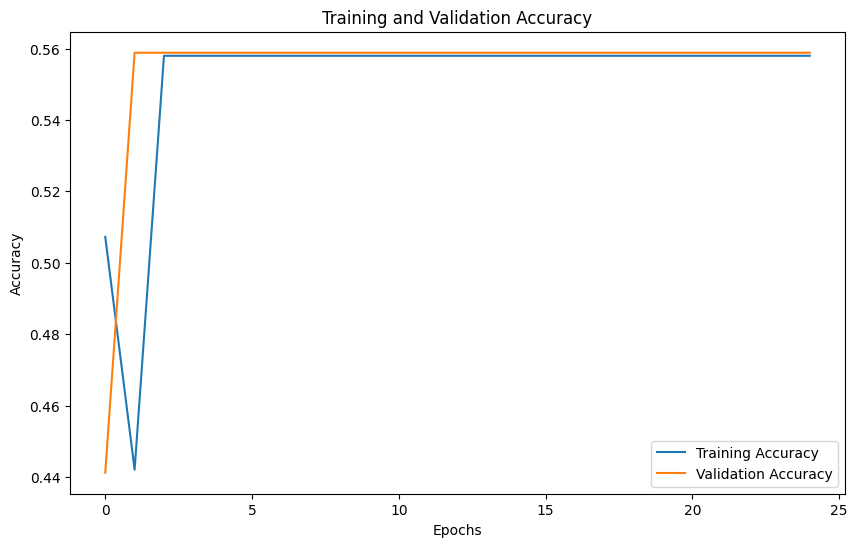

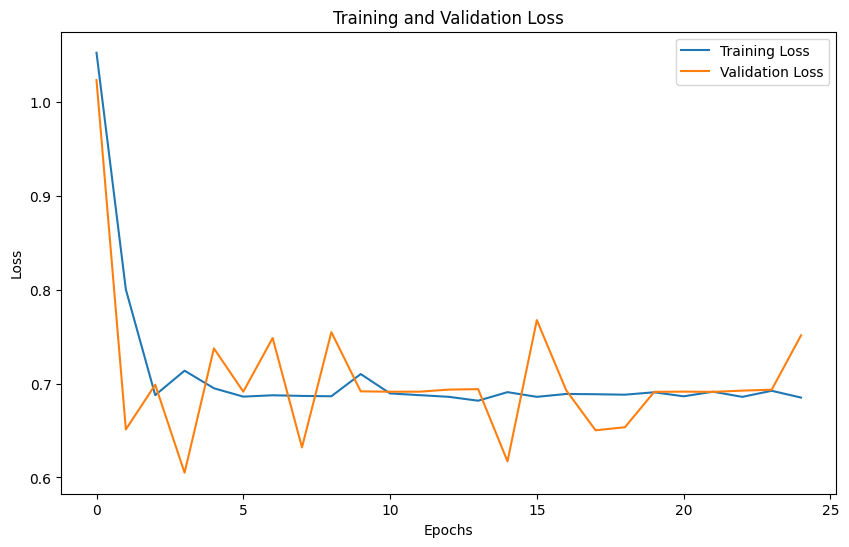

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD

# Definir generadores de imágenes con aumento de datos
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2,
    fill_mode='constant',
    validation_split=0.2  # Reservar 20% de los datos para validación
)

data_dir = 'db_unal/organized/images/raw'

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    #batch_size=50,
    class_mode='binary',
    subset='training'  # Especificar que esto es para el conjunto de entrenamiento
)

validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    #batch_size=20,
    class_mode='binary',
    subset='validation'  # Especificar que esto es para el conjunto de validación
)

# Cargar modelo preentrenado
base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congelar capas base
for layer in base_model.layers:
    layer.trainable = False

# Añadir nuevas capas
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compilar el modelo
model.compile(optimizer=SGD(learning_rate=0.1, momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])

# Calcular los steps per epoch y validation steps
#train_steps = int(np.ceil(train_generator.samples / train_generator.batch_size))
#val_steps = int(np.ceil(validation_generator.samples / validation_generator.batch_size))

# Entrenar el modelo
history = model.fit(
    train_generator,
    #steps_per_epoch=train_steps,
    validation_data=validation_generator,
    #validation_steps=val_steps,
    epochs=25
)

# Retrieve accuracy results on training and validation data sets for each training epoch.
acc = history.history['accuracy']  # Training accuracy
val_acc = history.history['val_accuracy']  # Validation accuracy

# Retrieve loss results on training and validation data sets for each training epoch.
loss = history.history['loss']  # Training loss
val_loss = history.history['val_loss']  # Validation loss

# Determine the number of epochs, based on the length of the accuracy list.
epochs = range(len(acc))

# Plot training and validation accuracy as a function of epochs.
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')  # Set the title of the graph
plt.xlabel('Epochs')  # Label the x-axis as 'Epochs'
plt.ylabel('Accuracy')  # Label the y-axis as 'Accuracy'
plt.legend()  # Add a legend to distinguish training vs. validation

# Plot training and validation loss as a function of epochs.
plt.figure(figsize=(10, 6))  # Create a new figure for loss visualization
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')  # Set the title of the graph
plt.xlabel('Epochs')  # Label the x-axis as 'Epochs'
plt.ylabel('Loss')  # Label the y-axis as 'Loss'
plt.legend()  # Add a legend to distinguish training vs. validation

### **Large Version**

#### **Adam Optimizer**

#### **SGD optimizer**

## **ResNet**

### **ResNet50**

#### **Adam Optimizer**

#### **SGD Optimizer**

Found 192 images belonging to 2 classes.
Found 47 images belonging to 2 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step
Epoch 1/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.5300 - loss: 0.7053 - val_accuracy: 0.5532 - val_loss: 0.7529
Epoch 2/25


C:\Users\alema\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 975ms/step - accuracy: 0.5231 - loss: 0.7232 - val_accuracy: 0.5532 - val_loss: 0.7078
Epoch 4/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.5518 - loss: 0.6989 - val_accuracy: 0.4468 - val_loss: 0.7168
Epoch 6/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.4966 - loss: 0.7170 - val_accuracy: 0.5532 - val_loss: 0.6899
Epoch 8/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 9/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 969ms/step - accura

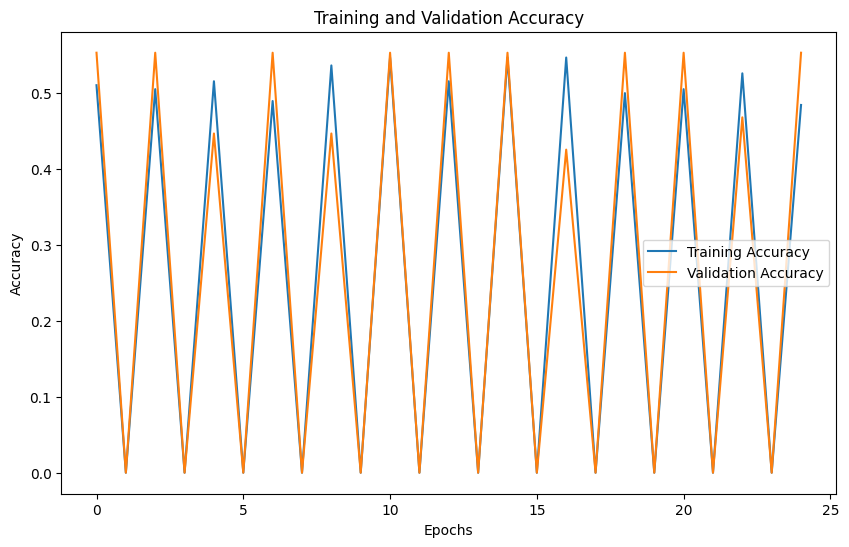

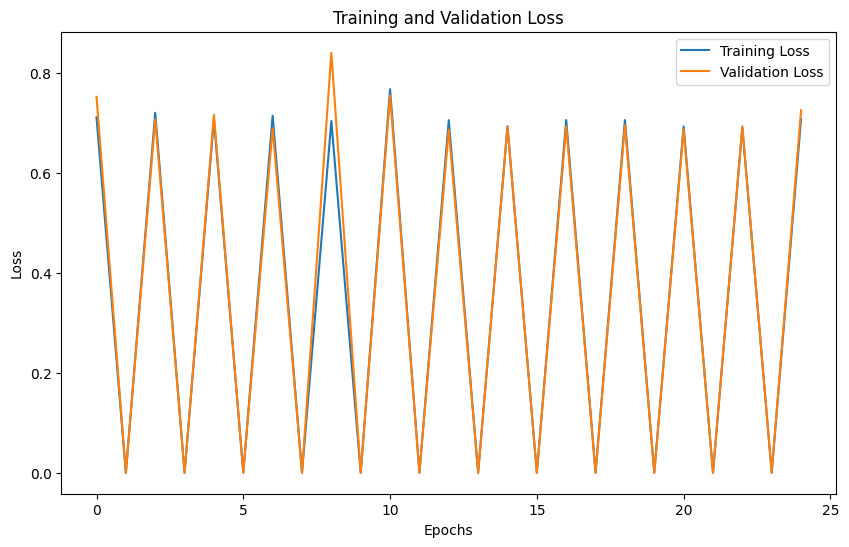

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD

# Definir generadores de imágenes con aumento de datos
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Reservar 20% de los datos para validación
)

data_dir = 'db_unal/organized/images/cropped'

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=20,
    class_mode='binary',
    subset='training'  # Especificar que esto es para el conjunto de entrenamiento
)

validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=6,
    class_mode='binary',
    subset='validation'  # Especificar que esto es para el conjunto de validación
)

# Cargar modelo preentrenado
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congelar capas base
for layer in base_model.layers:
    layer.trainable = False

# Añadir nuevas capas
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compilar el modelo
model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])

# Calcular los steps per epoch y validation steps
train_steps = int(np.ceil(train_generator.samples / train_generator.batch_size))
val_steps = int(np.ceil(validation_generator.samples / validation_generator.batch_size))

# Entrenar el modelo
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    validation_data=validation_generator,
    validation_steps=val_steps,
    epochs=25
)

# Retrieve accuracy results on training and validation data sets for each training epoch.
acc = history.history['accuracy']  # Training accuracy
val_acc = history.history['val_accuracy']  # Validation accuracy

# Retrieve loss results on training and validation data sets for each training epoch.
loss = history.history['loss']  # Training loss
val_loss = history.history['val_loss']  # Validation loss

# Determine the number of epochs, based on the length of the accuracy list.
epochs = range(len(acc))

# Plot training and validation accuracy as a function of epochs.
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')  # Set the title of the graph
plt.xlabel('Epochs')  # Label the x-axis as 'Epochs'
plt.ylabel('Accuracy')  # Label the y-axis as 'Accuracy'
plt.legend()  # Add a legend to distinguish training vs. validation

# Plot training and validation loss as a function of epochs.
plt.figure(figsize=(10, 6))  # Create a new figure for loss visualization
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')  # Set the title of the graph
plt.xlabel('Epochs')  # Label the x-axis as 'Epochs'
plt.ylabel('Loss')  # Label the y-axis as 'Loss'
plt.legend()  # Add a legend to distinguish training vs. validation

### **ResNet101**

#### **Adam Optimizer**

#### **SGD Optimizer**

## **VGG**

### **VGG16**

### **VGG19**

## **Xception**

## **DenseNet**